In [1]:
from langgraph.graph import START, END, StateGraph
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_ollama import OllamaEmbeddings, OllamaLLM
from typing import TypedDict, Annotated, Sequence
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph.message import add_messages
from langchain.tools.retriever import create_retriever_tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain import hub
from IPython.display import Image, display
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# llm = OllamaLLM(model = "llama3.2")
llm=ChatGroq(model_name="Gemma2-9b-It")
embedding = OllamaEmbeddings(model = "nomic-embed-text")

In [3]:
loader = WebBaseLoader(web_path="https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/overview-identity")
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
docs = splitter.split_documents(docs)
docs

[Document(metadata={'source': 'https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/overview-identity', 'title': 'What is the Azure AI Face service? - Azure AI services | Microsoft Learn', 'description': 'The Azure AI Face service provides AI algorithms that you use to detect, recognize, and analyze human faces in images.', 'language': 'en-us'}, page_content='What is the Azure AI Face service? - Azure AI services | Microsoft Learn\n\n\n\n\nSkip to main content\n\n\nThis browser is no longer supported.\nUpgrade to Microsoft Edge to take advantage of the latest features, security updates, and technical support.\n\nDownload Microsoft Edge\nMore info about Internet Explorer and Microsoft Edge\n\n\n\n\n\n\n\n\n\n\n\n\n\nTable of contents\n\n\n\nExit focus mode\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nRead in English\n\n\n\n\nSave\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nTable of contents\n\n\n\nRead in English\n\n\n\n\nSave\n\n\n\n\n\nAdd to plan\n\n\n\n\nEdit\n\n\nShare 

In [5]:
vector_store = Chroma.from_documents(
    collection_name = "agentic_rag", embedding=embedding, documents=docs
)

retriever = vector_store.as_retriever()

retriever_tool=create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Azure fce services.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )

In [7]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


class DocumentGrader(BaseModel):
    score:bool =  Field(..., description="A binary score, which is True if question is related to the given information, otherwise False")

In [8]:
tools = [retriever_tool]
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    
    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content
        prompt=PromptTemplate(
        template="""You are a helpful assistant. Whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
            
        chain = prompt | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        print("AGENT RESPONSE")
        return {"messages": [response]}

In [9]:
def restruture_question(state: AgentState):
    print("=== RESTRUCTURE QUESTION ===")

    question = state['messages'][0]
    prompt_template = ChatPromptTemplate.from_template(
        [
            SystemMessage(
                """
                    Understand the semnatic meaning and inherent meaning of the question.
                    Without any previous context, restructure the question keeping the inherent meaning same.
                """
            ),
            ("human",  """"
                question: {question}
             """)
        ]
    )

    chain = prompt_template | llm
    response = chain.invoke({'question': question})
    return {'messages': response}

In [15]:
def grade_docuements(state: AgentState):
    print("=== Documnent Relevance ===")
    llm_with_structure_op=llm.with_structured_output(DocumentGrader)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result: DocumentGrader = chain.invoke({"question": question, "context": docs})
    score = scored_result.score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite" #this should be a node name

In [11]:
def retrieve_document(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content
    
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}
    

In [ ]:
wf = StateGraph(AgentState)
wf.add_node("AI_Assistant", ai_assistant)
wf.add_node("Vector_Retriever", ToolNode(tools))
wf.add_node("Generate_Answer", retrieve_document)
wf.add_node("Question_Rewriter", restruture_question)

wf.add_edge(START, "AI_Assistant")
wf.add_edge("Question_Rewriter", "AI_Assistant")
wf.add_conditional_edges("AI_Assistant", tools_condition, {"tools": "Vector_Retriever", END: END})
wf.add_conditional_edges("Vector_Retriever", grade_docuements, {'generate': "Generate_Answer", 'rewrite': "Question_Rewriter"})
wf.add_edge("Generate_Answer", END)

app = wf.compile()

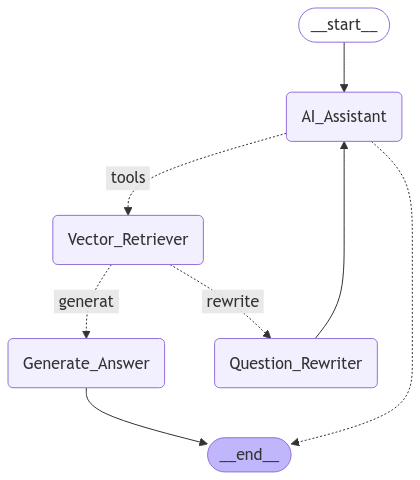

In [13]:
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
app.invoke({'messages': ["What is Face service in Azure?"]})

---CALL AGENT---
AGENT RESPONSE


{'messages': [HumanMessage(content='What is Face service in Azure?', additional_kwargs={}, response_metadata={}, id='2584deba-7340-4d42-86c3-d8b7f3d285b5'),
  AIMessage(content='\\\n\n\nMake\\}\n\n$\\"}\n\n\n"\n\n\n"\n\n\n\\}\n\n\nChooseThe\n\nRe}\n\n\\item\n\n},\n\n\n\n"The\n\nchoose"\n\n\n\n"\n\n\n"\n\n$\\quad"\n\n\n"week"\n\n\nThe\n\n"\n\n\n\n"\n\n\n"The\n\n\n"}}-"\n\nChoose"\n\n\n"",\n\n\n\n"The\n\n\n",\n\n"\n\n\n"\n\nWe"The\n\n$}\\\\\n\nChoose"\n\n":\\\\\\t}\n\n\\"}\n\n\n\n}"]"\n\n\n\\\n\n\n"\n\n\n\n"\n\n\n"\n\n\\href\\}\n\n\n\n\\item\n\n\n\n}}$,\n\n\nwhich-\n\n\n\n",\n\n\n\nThe\n\n: "\n\n\\",""\n\nThe\n\n\n\n\n"\n\n\n"\n\nQ"","\n\nQ"\n\n$"\n\n\nitemset"\n\n\n\\{"\n\n",\n\n\nThe1"\n\n\n"the\n\n\n"\n\n\n"\n\n\n"\n\nChoose"\n\nThat\n\n\n"\n\n\n"\n\n\n"\n\n\n"\n\n\n"\n\nQ"," The\n\n\nThe\n\n\n"\n\nQ",\n\n\n"\n\n\nThe\n\n\n\n"Q"Q\'",\n\n\n"\n\n\n\n\n"\n\n"Q"The\n\n\nThe\n\n\nQ}\n\n\n"\n\n$\\quad"Q"Q\n\n\n"\n\n\nchoose"Q"\n\n\n"\n\nQ"\n\n$",\n\n\n\n"\n\n\n"\n\n\nQ\n\n\n"f\n\n\n"","chQ\